# Predicting sea kelp coverage based on environmental variables

By: Gabija Posiunaite, Tiantian Shi, Zixiao Zhang



In this code we use the Random Forester species distribution model for modelling kelp coverage around Tasmania. Then the trained model is used for predicting the coverage for future decades upder diffrent emision scenarios.

## Basic prep

In [12]:
#libraries libraries
import netCDF4
import xarray as xr
from markdown_it.rules_inline.backticks import regex
from netCDF4 import Dataset
import rasterio
import geopandas as gpd
import statsmodels.api as sm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import Point, box
import contextily as ctx
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import math
import joblib

In [13]:
# Defining the latitude and longitude range for target area of Tasmania
lat_min, lat_max = -44, -40
long_min, long_max = 144, 149

## Enviromental Variables

We run throught the same code just changing the file names in order to filter all datasets for the geographical bounds of Tasmania

In [14]:
# Opening the NetCDF file
#ds = xr.open_dataset('Data/2050_cuv_us.nc')

# Filtering the dataset by latitude and longitude
#filtered_file = ds.where((ds['latitude'] >= lat_min) & (ds['latitude'] <= lat_max) &
#                      (ds['longitude'] >= long_min) & (ds['longitude'] <= long_max), drop=True)

#Saving the filtered data
#filtered_file.to_netcdf('Data/2050_Tas_cuv_us.nc')

Now that the enviromental data is ready to use we can open them up an read the NetCDF files into xarray datasets that will be ready to use for the moddeling

In [15]:
#2000-2010
sst_data = xr.open_dataset('Data/Tas_SST.nc')
cuv_data = xr.open_dataset('Data/Tas_speed.nc')
ph_data = xr.open_dataset('Data/Tas_Ph.nc')

In [16]:
#2020-2030
#mild
#sst_mild_2020 = xr.open_dataset('Data/2020_Tas_sst_mild.nc')
#cuv_mild_2020 = xr.open_dataset('Data/2020_Tas_cuv_mild_2.nc')
#ph_mild_2020 = xr.open_dataset('Data/2020_Tas_ph_mild.nc')
#moderate
#sst_mod_2020 = xr.open_dataset('Data/2020_Tas_sst_mod.nc')
#cuv_mod_2020 = xr.open_dataset('Data/2020_Tas_cuv_mod.nc')
#ph_mod_2020 = xr.open_dataset('Data/2020_Tas_ph_mod.nc')
#as usual
#sst_us_2020 = xr.open_dataset('Data/2020_Tas_sst_us.nc')
#cuv_us_2020 = xr.open_dataset('Data/2020_Tas_cuv_us.nc')
#ph_us_2020 = xr.open_dataset('Data/2020_Tas_ph_us.nc')

#2050-2060
#mild
#sst_mild_2050 = xr.open_dataset('Data/2050_Tas_sst_mild.nc')
#cuv_mild_2050 = xr.open_dataset('Data/2050_Tas_cuv_mild.nc')
#ph_mild_2050 = xr.open_dataset('Data/2050_Tas_ph_mild.nc')
#moderate
#sst_mod_2050 = xr.open_dataset('Data/2050_Tas_sst_mod.nc')
#cuv_mod_2050 = xr.open_dataset('Data/2050_Tas_cuv_mod.nc')
#ph_mod_2050 = xr.open_dataset('Data/2050_Tas_ph_mod.nc')
#as usual
#sst_us_2050 = xr.open_dataset('Data/2050_Tas_sst_us.nc')
#cuv_us_2050 = xr.open_dataset('Data/2050_Tas_cuv_us.nc')
#ph_us_2050 = xr.open_dataset('Data/2050_Tas_ph_us.nc')


We also prep for visualisation by creating a base map of Tasmania that then we can use for all plots.

In [17]:
#Creating a basemap function to ease with data visualisation
def base_map(ax):
    """
    Function to set up a base map for a given axis (ax).
    """
    # Seting the extent to cover Tasmania
    ax.set_extent([144, 149, -44, -40], crs=ccrs.PlateCarree())

    # Adding land without coastlines or oceans
    ax.add_feature(cfeature.LAND, edgecolor='black')

    # Adding gridlines and labels
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = False
    gl.right_labels = False

    return ax


## Preparation of Kelp Coverage data

The Kelp coverage data is filtered for the 2000-2010 decade and the average values for that decade are found for each data point.

---



In [18]:
#df= pd.read_csv(r'Data/kelp_original.csv')
#sorted_data = df[['Study','Site','Longitude','Latitude','year','percent_cover','percent_cover_STD']]

#Aus_Kelp = sorted_data.query('`Study` == "KelpCover_Temperate_Australia"')

# Filter the DataFrame for data points within Tasmania
#Tas_Kelp = Aus_Kelp[
 # (Aus_Kelp['Latitude'] >= lat_min) & (Aus_Kelp['Latitude'] <= lat_max) &
 # (Aus_Kelp['Longitude'] >= long_min) & (Aus_Kelp['Longitude'] <= long_max)
#]
 # Filter the DataFrame for the years between 2000 and 2010
#filtered_df = Tas_Kelp[(Tas_Kelp['year'] >= 2000) & (Tas_Kelp['year'] <= 2010)]

#Group by 'Site', calculate the average kelp coverage for each site
# Assuming the kelp coverage data is in a column named 'Kelp_Coverage'
#Tas_Kelp_filtered = filtered_df.groupby('Site', as_index=False).agg(
 #   Average_Kelp_Coverage=('percent_cover', 'mean'),
 #  Longitude=('Longitude', 'first'),  # Assumes Longitude is the same for each site
 #  Latitude=('Latitude', 'first')    # Assumes Latitude is the same for each site
#)
# Save the resulting data to a new CSV file
#Tas_Kelp_filtered.to_csv(r'Kelp_avg_filtered.csv', index=False)
Tas_Kelp_filtered= pd.read_csv(r'Data/Kelp_avg_filtered.csv')


Now that the kelp coverage data is filered and averaged out we can visualise it through a scatter map.

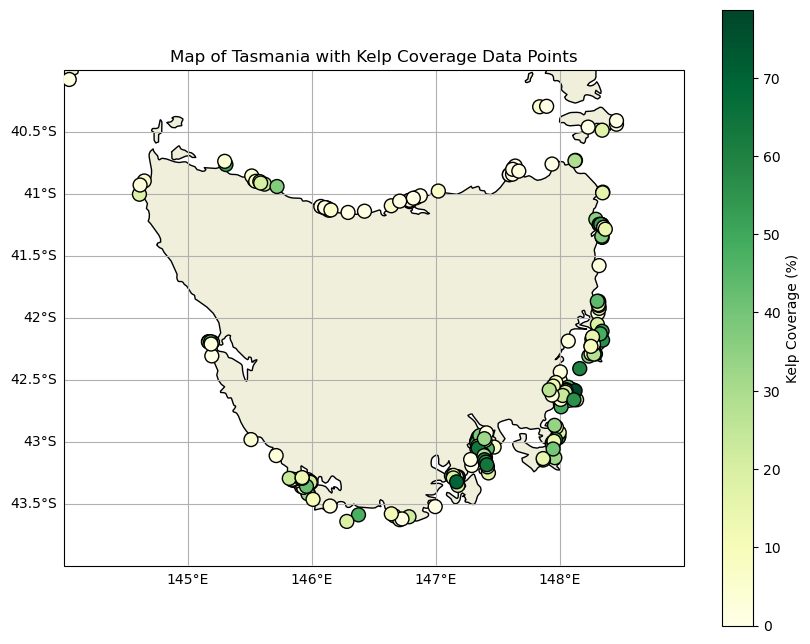

206


In [19]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
base_map(ax)

# Plot the filtered data points with a color map based on kelp coverage
sc = ax.scatter(
    Tas_Kelp_filtered['Longitude'], 
    Tas_Kelp_filtered['Latitude'], 
    c=Tas_Kelp_filtered['Average_Kelp_Coverage'],
    cmap='YlGn',
    s=100, 
    edgecolor='black', 
    zorder=5, 
    transform=ccrs.PlateCarree()
)

# Add a color bar for kelp coverage
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('Kelp Coverage (%)')

# Add a title
plt.title('Map of Tasmania with Kelp Coverage Data Points')

# Show the plot
plt.show()
print(len(Tas_Kelp_filtered))


## Preparation of Environmental data for the model

In order to give the model more data to work with we are generating random background points (pseudo points) of absence.

In [29]:
#download the Shapefile of the ocean and land
land_shapefile_path = r'shapefile/ne_110m_land.shp'
ocean_shapefile_path = r'shapefile/ne_10m_ocean.shp'
#Load land and ocean shapefiles
land = gpd.read_file(land_shapefile_path)
ocean = gpd.read_file(ocean_shapefile_path)

# Filter to include only the Tasmania region
tasmania_land = land.cx[long_min:long_max, lat_min:lat_max]
tasmania_ocean = ocean.cx[long_min:long_max, lat_min:lat_max]

# Creating a function to generate random points
def generate_random_points(bbox, n_points):
    minx, miny, maxx, maxy = bbox.bounds
    xs = np.random.uniform(minx, maxx, n_points)
    ys = np.random.uniform(miny, maxy, n_points)
    return np.column_stack((xs, ys))

# Bounding box for random points
bbox = box(long_min, lat_min, long_max, lat_max)
n_points = 1000
random_points = generate_random_points(bbox, n_points)

# Convert random points to GeoDataFrame
random_gdf = gpd.GeoDataFrame(
    geometry=[Point(xy) for xy in random_points],
    crs='EPSG:4326'
)

# Filter random points to keep only those within the ocean (not on land)
random_gdf = random_gdf[~random_gdf.within(tasmania_land.unary_union)]

Combining the presence data with the pseudo points

In [30]:
# Convert to pandas DataFrame with longitude and latitude
background = pd.DataFrame({
    'longitude': [point.x for point in random_gdf.geometry],
    'latitude': [point.y for point in random_gdf.geometry]
})

# Add presence/absence indicator (0 for pseudo-absence)
background['pa'] = 0

# Prepare presence points from kelp observation data
presence = Tas_Kelp_filtered[['Longitude', 'Latitude', 'Average_Kelp_Coverage']].copy()
presence.columns = ['longitude', 'latitude', 'pa']  # Rename columns to match

# Combine the presence and pseudo-absence data into a single DataFrame
all_points = pd.concat([presence, background], ignore_index=True)

# Perform a reality check on the combined dataset
print(all_points.head())


   longitude  latitude    pa
0   146.9961  -43.5252   0.6
1   147.3419  -42.9666  47.5
2   145.5405  -40.8901  14.0
3   145.5364  -40.8905   0.8
4   147.1817  -43.2853  14.5


Now we can visualise the kelp coverage data together with the added points

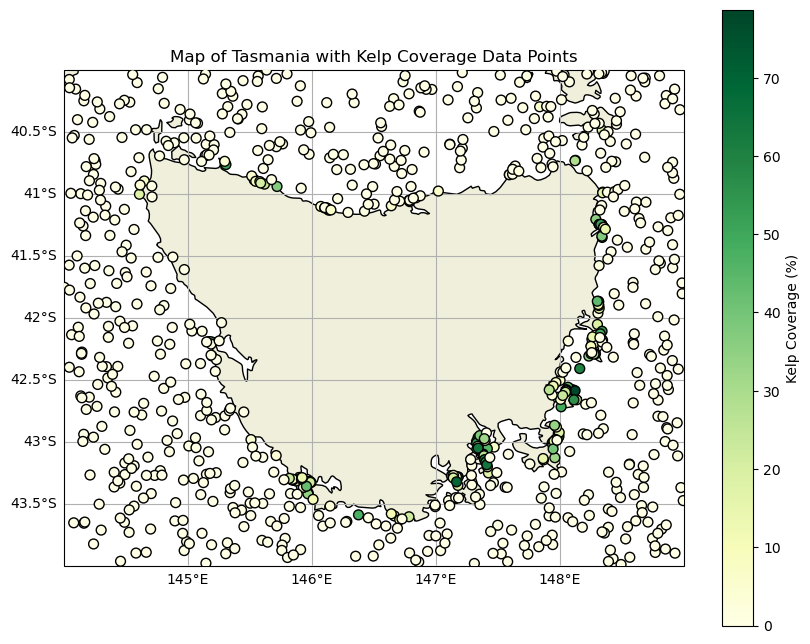

In [31]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
base_map(ax) #using the basemap

#setting up a new scatter map
sc = ax.scatter(
    all_points['longitude'], 
    all_points['latitude'], 
    c=all_points['pa'], 
    cmap='YlGn',
    s=50, 
    edgecolor='black', 
    zorder=5, 
    transform=ccrs.PlateCarree()
)

#Adding a colourbar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('Kelp Coverage (%)')

# Add a title
plt.title('Map of Tasmania with Kelp Coverage Data Points')

# Show the plot
plt.show()


Combining the environmental data with the presence and pseudo points. Here we are defining a few data processing functions that will later on make dealing with future scenario enviromental data more easily.


In [32]:
# Extract coordinates (longitude and latitude) from all_points DataFrame
coordinates = all_points[['longitude', 'latitude']].values

# Define a function to extract the nearest climate data and convert arrays to scalar values
def extract_climate_data(dataset, var_name, coords):
    values = []
    for lon, lat in coords:
        try:
            # Use xarray's .sel() method to get nearest values for each pair of coordinates
            value = dataset[var_name].sel(longitude=lon, latitude=lat, method='nearest').values
            # Extract scalar value if it's an array, otherwise append as is
            values.append(value.item() if np.ndim(value) > 0 else value)
        except Exception as e:
            # Append NaN in case of any issue during extraction
            print(f"Error extracting climate data for ({lon}, {lat}): {e}")
            values.append(np.nan)
    return values

# Extract climate data for sst, cuv, and ph
sst_values = extract_climate_data(sst_data, 'thetao_mean', coordinates)
cuv_values = extract_climate_data(cuv_data, 'sws_mean', coordinates)
ph_values = extract_climate_data(ph_data, 'ph_mean', coordinates)

def process_climate_data(all_points, sst_values, cuv_values, ph_values):
    """
    Combine climate data (sst, cuv, ph) with geographic points, then cleaning by removing rows with NaN values.
    
    Parameters:
    - all_points: DataFrame containing geographic points (e.g., longitude, latitude).
    - sst_values: List or array of sea surface temperature (sst) values.
    - cuv_values: List or array of current velocity (cuv) values.
    - ph_values: List or array of pH values.
    
    Returns:
    - points_climate_cleaned: DataFrame with combined and cleaned climate and geographic data.
    """
    
    # Convert the extracted enviromanta; data into a DataFrame
    bioclim_extract = pd.DataFrame({
        'sst': sst_values,
        'cuv': cuv_values,
        'ph': ph_values
    })

    # Combine climate data with the all_points DataFrame
    points_climate = pd.concat([all_points, bioclim_extract], axis=1)

    # Check how many NaN values exist before dropping
    print(f"Number of rows with NaN values before dropping: \n{points_climate.isna().sum()}")

    # Drop rows where any column has NaN values (including sst, cuv, ph)
    points_climate_cleaned = points_climate.dropna(how='any')  # Removes any row with NaN in any column

    # Verify the number of rows after cleaning NaN
    print(f"Number of rows after removing NaN: \n{points_climate_cleaned.isna().sum()}")
    
    return points_climate_cleaned

#Cleaning the enviromental data
points_climate_cleaned = process_climate_data(all_points, sst_values, cuv_values, ph_values)
#saving it as a csv file
#points_climate_cleaned.to_csv(r'points_cleaned_original.csv', index=False)
# Lets check how our data looks like
#print(points_climate_cleaned.head())


Number of rows with NaN values before dropping: 
longitude     0
latitude      0
pa            0
sst          94
cuv          94
ph           94
dtype: int64
Number of rows after removing NaN: 
longitude    0
latitude     0
pa           0
sst          0
cuv          0
ph           0
dtype: int64


Visualising the envisomental data fot our backround poins.

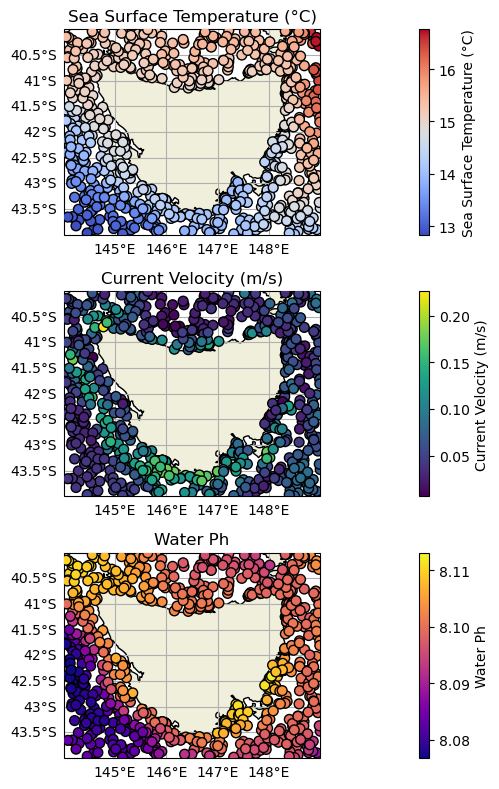

In [33]:
# Set up a figure with three subplots (1 row, 3 columns)
fig, axes = plt.subplots(3, 1, figsize=(20, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Variables for looping
variables = ['sst', 'cuv', 'ph']
titles = ['Sea Surface Temperature (°C)', 'Current Velocity (m/s)', 'Water Ph']
cmaps = ['coolwarm', 'viridis', 'plasma']  # Different colormaps for each variable

# Loop through the axes and variables to create three maps
for i, ax in enumerate(axes):
    # Use the base_map function to initialize each axis
    base_map(ax)

    # Plot the data points for the respective variable
    sc = ax.scatter(
        points_climate_cleaned['longitude'], 
        points_climate_cleaned['latitude'], 
        c=points_climate_cleaned[variables[i]],  # Select the variable (sst, cuv, or ph)
        cmap=cmaps[i],  # Colormap specific to the variable
        s=50, 
        edgecolor='black', 
        zorder=5, 
        transform=ccrs.PlateCarree()
    )

    # Add a color bar
    cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.05)
    cbar.set_label(f'{titles[i]}')

    # Add a title to each subplot
    ax.set_title(titles[i])

# Show the entire plot with three maps
plt.tight_layout()
plt.show()


## Preparation of training and testing datasets

With our enviromental data and kelp coverage data geing all in one file, we can separate the dataset into training and testing data.

In [34]:
# Define number of splits (folds)
n_splits = 5

# Create an empty column for fold assignments
points_climate_cleaned['fold'] = np.nan

# Shuffle the data
np.random.seed(20210707)  # Set seed for reproducibility
points_climate_cleaned = points_climate_cleaned.sample(frac=1, random_state=20210707).reset_index(drop=True)

# Split the data into n_splits
folds = np.array_split(points_climate_cleaned, n_splits)

# Assign fold numbers to each split
for i in range(n_splits):
    folds[i]['fold'] = i + 1

# Combine back the folds into the original dataframe
points_climate_cleaned = pd.concat(folds).reset_index(drop=True)

# Check fold distribution
print(points_climate_cleaned['fold'].value_counts())

# Separating the datasets
# Use fold == 1 for the testing set
testing = points_climate_cleaned[points_climate_cleaned['fold'] == 1]

# Use fold != 1 for the training set
training = points_climate_cleaned[points_climate_cleaned['fold'] != 1]

# Check the sizes of training and testing sets
print(f"Training set size: {training.shape}")
print(f"Testing set size: {testing.shape}")


1    148
2    148
3    148
4    148
5    148
Name: fold, dtype: int64
Training set size: (592, 7)
Testing set size: (148, 7)


# Model building and evaluation

Finally we can define and train our model. We decided to use the Random Forester model as the relashonship between our enviromental variables and kelp coverage data is not exactly linear. Moreover, we tested the Linear model and it preformed worse.

In [35]:
# Prepare features and target from the training and testing datasets
features_train = training.drop(columns=['pa', 'fold', 'longitude', 'latitude'])
target_train = training['pa']

features_test = testing.drop(columns=['pa', 'fold', 'longitude', 'latitude'])
target_test = testing['pa']

# Initialize and fit the Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(features_train, target_train)

# Make predictions on the test set
predictions = rf_model.predict(features_test)

# Calculatig mean squared error for model evaluation
mse = mean_squared_error(target_test, predictions)
print(f'Mean Squared Error: {mse}')

# Calculating and printing the R^2 score
r_squared = r2_score(target_test, predictions)
print(f'R^2 Score: {r_squared}')

Mean Squared Error: 51.88732828468482
R^2 Score: 0.5761144834520415


We print out the mean squred error and the R squared of our model in order to evaluate its performance. For ease of use further we saved a model and we call it later. This way we can run our predictions using the same trained model when reruning the code.

In [36]:
# Save the trained model
#joblib.dump(rf_model, 'random_forest_model_m0.53_rs_0.60.pkl')

# Loading the model for future predictions
rf_model_loaded = joblib.load('random_forest_model_m0.53_rs_0.60.pkl')


## Current Decade (2000-2010)

Now that the model is complete we can see what prediction it makes for the 2000-2010 data we used to train it.

In [38]:
#reading the original prepped data
points_cleaned_original= pd.read_csv(r'Data/points_cleaned_original.csv')

In [39]:
#defining a function that will return predicted results
def predict_coverage(data, model):
    """
    Prepare features for prediction and create a DataFrame with predicted coverage along with longitude and latitude.
    
    Parameters:
    data (pd.DataFrame): The DataFrame containing the data for prediction.
    model (Any): The trained model to make predictions with.
    
    Returns:
    pd.DataFrame: A DataFrame with longitude, latitude, and the predicted coverage.
    """
    
    # Prepare features for prediction by dropping unnecessary columns
    features_predict = data.drop(columns=['pa', 'longitude', 'latitude'])
    
    # Make predictions on the new data
    predictions = model.predict(features_predict)
    
    # Create a DataFrame for the predictions along with latitude and longitude
    new_results = pd.DataFrame({
        'Longitude': data['longitude'].values,
        'Latitude': data['latitude'].values,
        'Predicted_Coverage': predictions
    })
    
    return new_results


Now using the original enviromental variables we can see what our model predicts. This way we can compare the known kelp coverage data with the models predictions.

In [40]:
#using the model to generate the predicted coverage
#original_results = predict_coverage(points_cleaned_original, rf_model_loaded)

# Filter the results to only include points that match Tas_Kelp_filtered
#original_results_filered = original_results.merge(Tas_Kelp_filtered[['Longitude', 'Latitude']], 
 #                                    on=['Longitude', 'Latitude'], 
 #                                    how='inner')

#Saving the result file for future analysis
#original_results_filered.to_csv(r'original_results_filered.csv', index=False)

#reading the predicted kelp coverage for 2000-2010
original_results_filered= pd.read_csv(r'Data/original_results_filered.csv')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


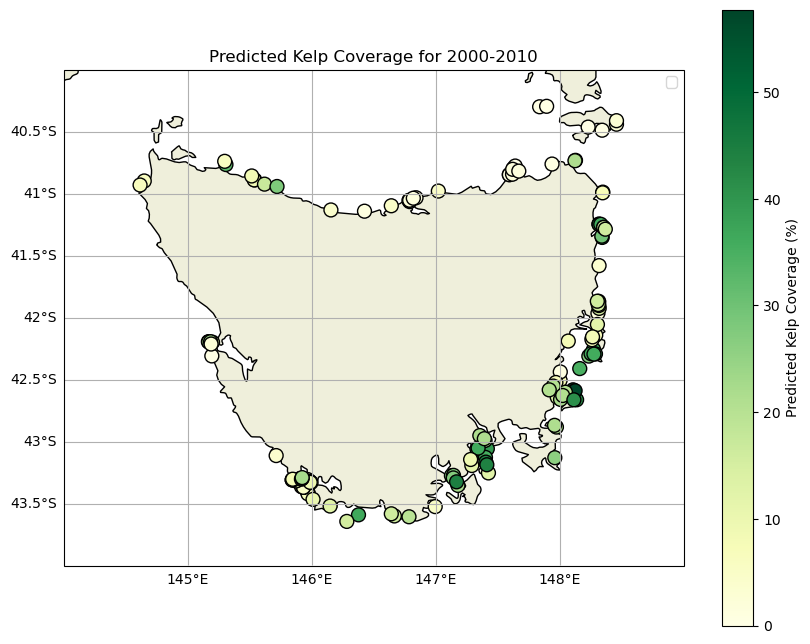

In [41]:
#Visualising the moddeled results
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
base_map(ax)

# Scatter plot of the points, colored by predicted kelp coverage
sc = ax.scatter(
    original_results_filered['Longitude'], 
    original_results_filered['Latitude'], 
    c=original_results_filered['Predicted_Coverage'],
    cmap='YlGn',
    s=100,
    edgecolor='black',
    transform=ccrs.PlateCarree()
)

# Add a color bar
cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('Predicted Kelp Coverage (%)')

# Set labels and title
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Predicted Kelp Coverage for 2000-2010')
plt.legend()

plt.show()


# Predictions for the Future

Now that we are satisfied with our model we can run it to see what kind of kelp coverage around Tasmania will it predict during diffrent IPCC climate change scenarios.

## Data Prep

We repeat the same data prep process as before, using the preveusly defined functions.

In [43]:
#2020
#Extracting the data
#sst_values_2020_mild = extract_climate_data(sst_mild_2020, 'thetao_mean', coordinates)
#cuv_values_2020_mild = extract_climate_data(cuv_mild_2020, 'sws_mean', coordinates)
#ph_values_2020_mild = extract_climate_data(ph_mild_2020, 'ph_mean', coordinates)

#sst_values_2020_mod = extract_climate_data(sst_mod_2020, 'thetao_mean', coordinates)
#cuv_values_2020_mod = extract_climate_data(cuv_mod_2020, 'sws_mean', coordinates)
#ph_values_2020_mod = extract_climate_data(ph_mod_2020, 'ph_mean', coordinates)

#sst_values_2020_us = extract_climate_data(sst_us_2020, 'thetao_mean', coordinates)
#cuv_values_2020_us = extract_climate_data(cuv_us_2020, 'sws_mean', coordinates)
#ph_values_2020_us = extract_climate_data(ph_us_2020, 'ph_mean', coordinates)

#cleaning and combining the datapoints
#points_cleaned_2020_mild = process_climate_data(all_points, sst_values_2020_mild, cuv_values_2020_mild, ph_values_2020_mild)
#points_cleaned_2020_mod = process_climate_data(all_points, sst_values_2020_mod, cuv_values_2020_mod, ph_values_2020_mod)
#points_cleaned_2020_us = process_climate_data(all_points, sst_values_2020_us, cuv_values_2020_us, ph_values_2020_us)

#saving to csv
#points_cleaned_2020_mild.to_csv(r'points_cleaned_2020_mild.csv', index=False)
#points_cleaned_2020_mod.to_csv(r'points_cleaned_2020_mod.csv', index=False)
#points_cleaned_2020_us.to_csv(r'points_cleaned_2020_us.csv', index=False)


#2050
#Extracting the data
#sst_values_2050_mild = extract_climate_data(sst_mild_2050, 'thetao_mean', coordinates)
#cuv_values_2050_mild = extract_climate_data(cuv_mild_2050, 'sws_mean', coordinates)
#ph_values_2050_mild = extract_climate_data(ph_mild_2050, 'ph_mean', coordinates)

#sst_values_2050_mod = extract_climate_data(sst_mod_2050, 'thetao_mean', coordinates)
#cuv_values_2050_mod = extract_climate_data(cuv_mod_2050, 'sws_mean', coordinates)
#ph_values_2050_mod = extract_climate_data(ph_mod_2050, 'ph_mean', coordinates)

#sst_values_2050_us = extract_climate_data(sst_us_2050, 'thetao_mean', coordinates)
#cuv_values_2050_us = extract_climate_data(cuv_us_2050, 'sws_mean', coordinates)
#ph_values_2050_us = extract_climate_data(ph_us_2050, 'ph_mean', coordinates)

#Cleaning and combining the datasets
#points_cleaned_2050_mild = process_climate_data(all_points, sst_values_2050_mild, cuv_values_2050_mild, ph_values_2050_mild)
#points_cleaned_2050_mod = process_climate_data(all_points, sst_values_2050_mod, cuv_values_2050_mod, ph_values_2050_mod)
#points_cleaned_2050_us = process_climate_data(all_points, sst_values_2050_us, cuv_values_2050_us, ph_values_2050_us)

#saving to csv
#points_cleaned_2050_mild.to_csv(r'points_cleaned_2050_mild.csv', index=False)
#points_cleaned_2050_mod.to_csv(r'points_cleaned_2050_mod.csv', index=False)
#points_cleaned_2050_us.to_csv(r'points_cleaned_2050_us.csv', index=False)

## Generaing future predictions

In [45]:
#Running the model using future data

#2020-2030
#mild_2020_results = predict_coverage(points_cleaned_2020_mild, rf_model_loaded)
#mod_2020_results = predict_coverage(points_cleaned_2020_mod, rf_model_loaded)
#us_2020_results = predict_coverage(points_cleaned_2020_us, rf_model_loaded)

#2050-2060
#mild_2050_results = predict_coverage(points_cleaned_2050_mild, rf_model_loaded)
#mod_2050_results = predict_coverage(points_cleaned_2050_mod, rf_model_loaded)
#us_2050_results = predict_coverage(points_cleaned_2050_us, rf_model_loaded)

Now that we run our model we only wanna look at the points that match the original kelp observation sites.

In [35]:
#2020-2030
# Filter the results to only include points that match Tas_Kelp_filtered
#mild_2020_results_filered = mild_2020_results.merge(Tas_Kelp_filtered[['Longitude', 'Latitude']], 
#                                     on=['Longitude', 'Latitude'], 
#                                     how='inner')

#mod_2020_results_filered = mod_2020_results.merge(Tas_Kelp_filtered[['Longitude', 'Latitude']], 
 #                                    on=['Longitude', 'Latitude'], 
 #                                    how='inner')

#us_2020_results_filered = us_2020_results.merge(Tas_Kelp_filtered[['Longitude', 'Latitude']], 
 #                                    on=['Longitude', 'Latitude'], 
 #                                    how='inner')

#saving the moddeld results
#mod_2020_results_filered.to_csv(r'mod_2020_results_filered.csv', index=False)
#us_2020_results_filered.to_csv(r'us_2020_results_filered.csv', index=False)
#mild_2020_results_filered.to_csv(r'mild_2020_results_filered.csv', index=False)

In [46]:
#2050-2060
#mild_2050_results_filered = mild_2050_results.merge(Tas_Kelp_filtered[['Longitude', 'Latitude']], 
#                                     on=['Longitude', 'Latitude'], 
#                                     how='inner')

#mod_2050_results_filered = mod_2050_results.merge(Tas_Kelp_filtered[['Longitude', 'Latitude']], 
#                                     on=['Longitude', 'Latitude'], 
#                                     how='inner')
                                
#us_2050_results_filered = us_2050_results.merge(Tas_Kelp_filtered[['Longitude', 'Latitude']], 
 #                                    on=['Longitude', 'Latitude'], 
#                                     how='inner')

#mild_2050_results_filered.to_csv(r'mild_2050_results_filered.csv', index=False)
mod_2050_results_filered.to_csv(r'mod_2050_results_filered.csv', index=False)
#us_2050_results_filered.to_csv(r'us_2050_results_filered.csv', index=False)

## Visualising the Results

In [47]:
#Read the result datasets
mild_2020_results_filered = pd.read_csv(r'Data/mild_2020_results_filered.csv')
mod_2020_results_filered = pd.read_csv(r'Data/mod_2020_results_filered.csv')
us_2020_results_filered = pd.read_csv(r'Data/us_2020_results_filered.csv')

mild_2050_results_filered = pd.read_csv(r'Data/mild_2050_results_filered.csv')
mod_2050_results_filered = pd.read_csv(r'Data/mod_2050_results_filered.csv')
us_2050_results_filered = pd.read_csv(r'Data/us_2050_results_filered.csv')

# Calculate the means
means = {
    '2000-2010 Actual': Tas_Kelp_filtered['Average_Kelp_Coverage'].mean(),
    '2000-2010 Predicted': original_results_filered['Predicted_Coverage'].mean(),
    '2020-2030 SSP 1-1.9': mild_2020_results_filered['Predicted_Coverage'].mean(),
    '2020-2030 SSP 2-4.5': mod_2020_results_filered['Predicted_Coverage'].mean(),
    '2020-2030 SSP 5-8.9': us_2020_results_filered['Predicted_Coverage'].mean(),
    '2050-2060 SSP 1-1.9': mild_2050_results_filered['Predicted_Coverage'].mean(),
    '2050-2060 SSP 2-4.5': mod_2050_results_filered['Predicted_Coverage'].mean(),
    '2050-2060 SSP 5-8.9': us_2050_results_filered['Predicted_Coverage'].mean()
}

# Print the means
for period, mean_value in means.items():
    print(f'{period}: {mean_value:.2f}')


2000-2010 Actual: 20.65
2000-2010 Predicted: 16.07
2020-2030 SSP 1-1.9: 0.23
2020-2030 SSP 2-4.5: 0.00
2020-2030 SSP 5-8.9: 0.38
2050-2060 SSP 1-1.9: 0.39
2050-2060 SSP 2-4.5: 0.14
2050-2060 SSP 5-8.9: 0.17


Now lets look at our maps:

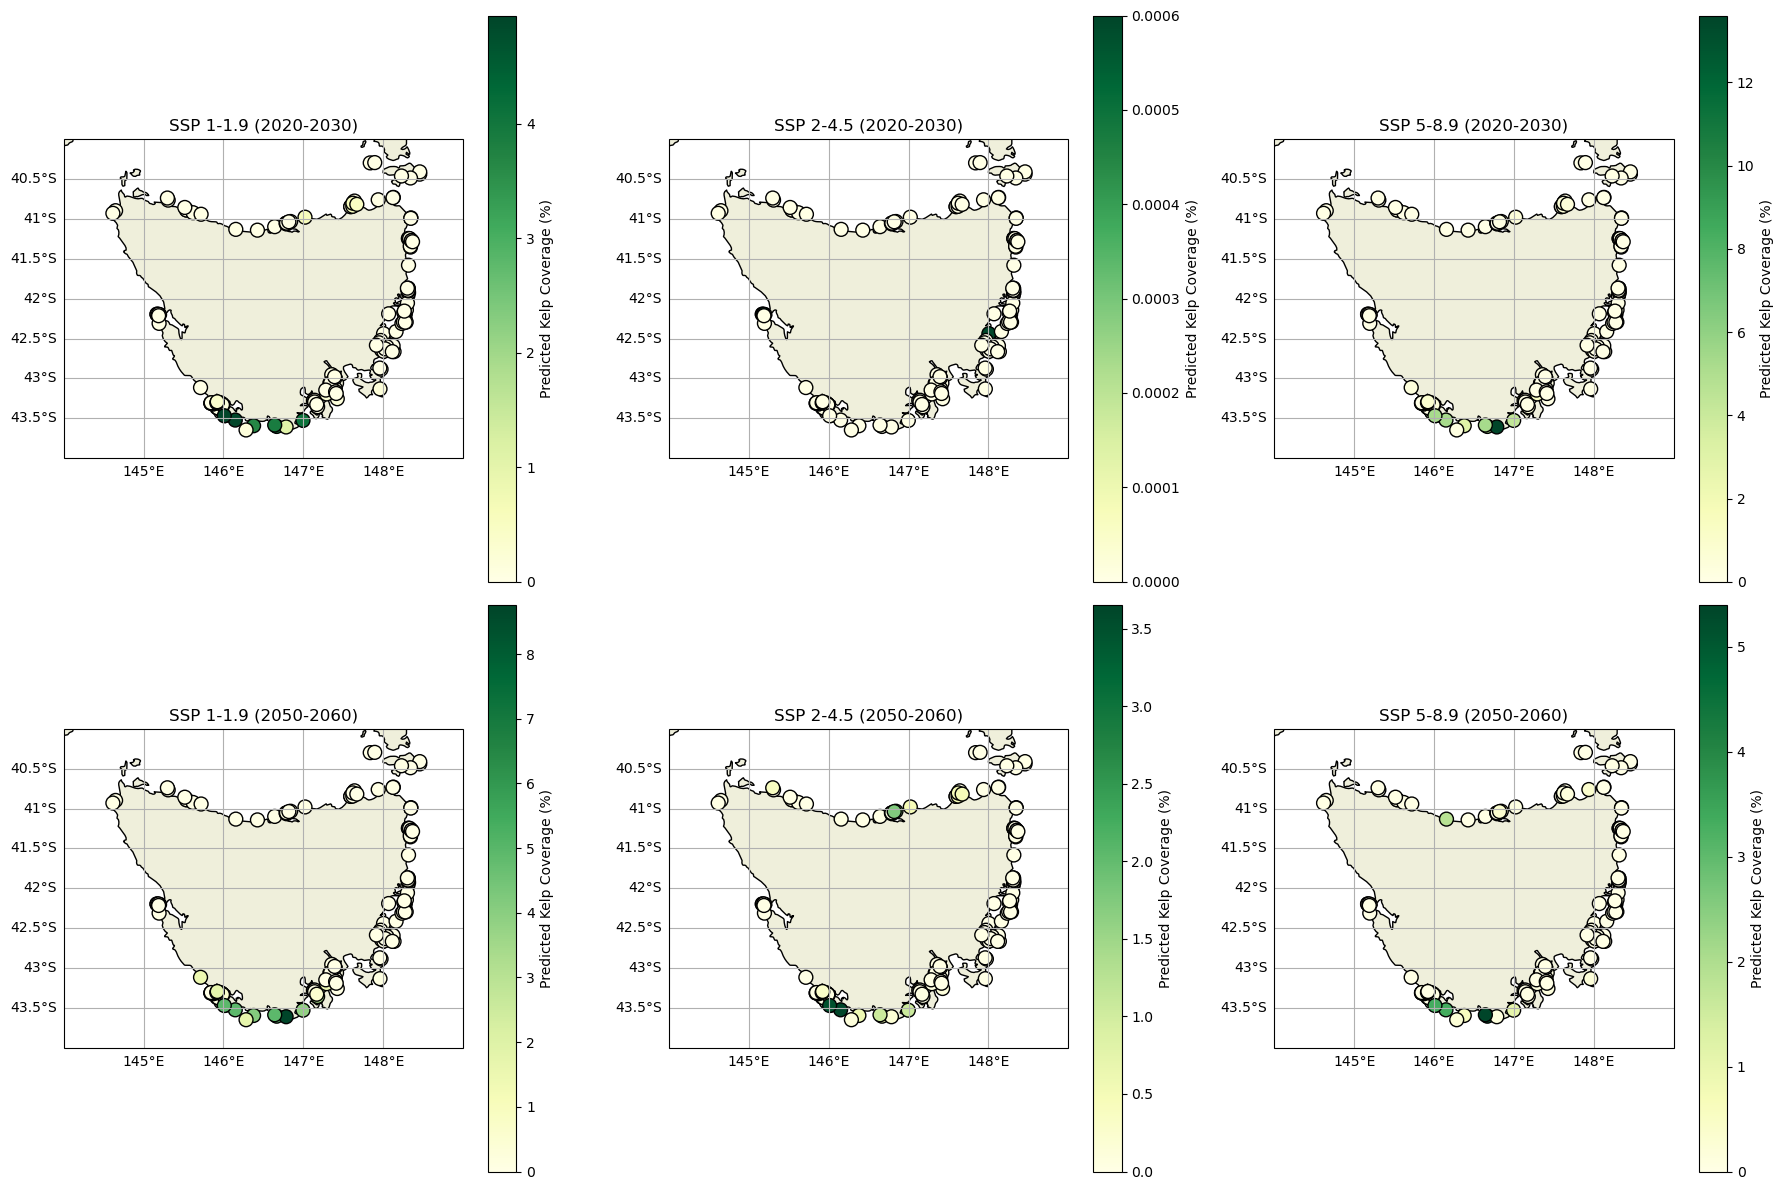

In [48]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

# Function to plot the data for all of Tasmania
def plot_map_tasmania(ax, data, title):
    sc = ax.scatter(
        data['Longitude'], 
        data['Latitude'], 
        c=data['Predicted_Coverage'], 
        cmap='YlGn', 
        s=100, 
        edgecolor='black', 
        transform=ccrs.PlateCarree()
    )
    cbar = plt.colorbar(sc, ax=ax, orientation='vertical', pad=0.05)
    cbar.set_label('Predicted Kelp Coverage (%)')
    ax.set_title(title)

# Create a figure with 6 subplots (2 rows, 3 columns)
fig, axes = plt.subplots(2, 3, figsize=(18, 12), subplot_kw={'projection': ccrs.PlateCarree()})

# First row (2020-2030 SSP scenarios)
plot_map_tasmania(axes[0, 0], mild_2020_results_filered, 'SSP 1-1.9 (2020-2030)')
plot_map_tasmania(axes[0, 1], mod_2020_results_filered, 'SSP 2-4.5 (2020-2030)')
plot_map_tasmania(axes[0, 2], us_2020_results_filered, 'SSP 5-8.9 (2020-2030)')

# Second row (2050-2060 SSP scenarios)
plot_map_tasmania(axes[1, 0], mild_2050_results_filered, 'SSP 1-1.9 (2050-2060)')
plot_map_tasmania(axes[1, 1], mod_2050_results_filered, 'SSP 2-4.5 (2050-2060)')
plot_map_tasmania(axes[1, 2], us_2050_results_filered, 'SSP 5-8.9 (2050-2060)')

# Set the base map for all subplots
for ax in axes.flat:
    base_map(ax)  # Assuming 'base_map' is already defined for Tasmania

# Display the plots
plt.tight_layout()
plt.show()
